# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

In [2]:
pd.options.display.float_format = '{:.5f}'.format
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00000,108.00000,2019-03-07T00:00:00,3,2.70000,16.00000,51.00000,8,NaN,...,25.00000,NaN,Санкт-Петербург,18863.00000,16028.00000,1.00000,482.00000,2.00000,755.00000,NaN
1,7,3350000.00000,40.40000,2018-12-04T00:00:00,1,NaN,11.00000,18.60000,1,NaN,...,11.00000,2.00000,посёлок Шушары,12817.00000,18603.00000,0.00000,NaN,0.00000,NaN,81.00000
2,10,5196000.00000,56.00000,2015-08-20T00:00:00,2,NaN,5.00000,34.30000,4,NaN,...,8.30000,0.00000,Санкт-Петербург,21741.00000,13933.00000,1.00000,90.00000,2.00000,574.00000,558.00000
3,0,64900000.00000,159.00000,2015-07-24T00:00:00,3,NaN,14.00000,NaN,9,NaN,...,NaN,0.00000,Санкт-Петербург,28098.00000,6800.00000,2.00000,84.00000,3.00000,234.00000,424.00000
4,2,10000000.00000,100.00000,2018-06-19T00:00:00,2,3.03000,14.00000,32.00000,13,NaN,...,41.00000,NaN,Санкт-Петербург,31856.00000,8098.00000,2.00000,112.00000,1.00000,48.00000,121.00000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

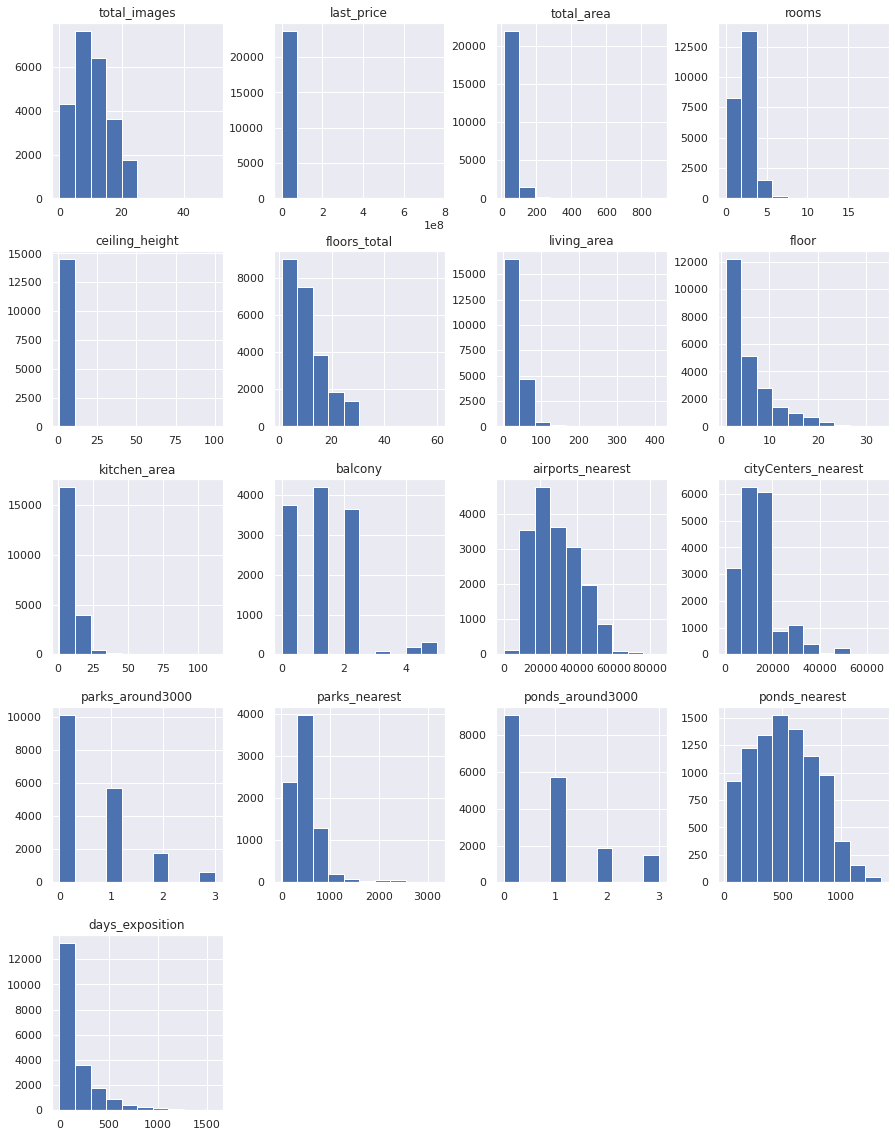

In [4]:
data.hist(figsize=(15, 20));

**Вывод:**

В датасете 23699 строк и 22 стобца. В 14 столбцах есть пропуски даных. Три столбца имеют целочисленный тип данных, два-логический, два-текстовый (следует проверить,почему был присвоен данный тип данных и изменить тип данных, при необходимости), остальные -вещественный.

На гистограммах сразу заметны нулевые значения, а также выбросы данных, например, на гистограмме с балконами, количеством комнат, общей площадью, жилой площадью, ценой (есть значения, близкие к нулю).
    
Необходимо поработать с пропусками данных, а также избавиться от выбросов.

## Предобработка данных

Выведем количество пропущенных значений для каждого столбца.

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

### Работа с пропусками

В большинстве столбцов присутсвуют пропуски.
- Заменим пропуски на 0 в следующих столбцах:
 - `balcony`
 - `parks_around3000`
 - `ponds_around3000`
- Заменим пропуски в столбце `is_apartment` на False.
- Заполним пропуски в столбце `living_area` и `kitchen_area`(с помощью коэффицента отношения к общей площади)
- Заполним пропуcки в столбце `ceiling_height` медианным занчением. Если мы их просто удалим, то лишимся 39% данных.

Если продавец не указал количество балконов, то большая вероятность, что их нет.

Данные по количеству парков и водоемов получены автоматически. Пустые значения скорее всего означают отстутствие парков и водоемов в районе 3 км. Сделаем дополнительную проверку по столбцам, указывающим расстояние до блийшего парка/водоема (`parks_nearest`, `ponds_nearest`). Проверим не содержат ли эти столбцы значения <=3000 м.

Если продавец ничего не указал в графе Апартаменты, то скорее всего это квартира.

В остальных столбцах сложно предложить логичную замену пропускам. Оставим оставшиеся пропуски, как есть.

Пропуски в данных, которые продавцы указывали вручную, связаны либо с тем, что продавцы не владели этой информацией, либо ввели данные неврного формата.

Пропуски в данных, полученнных атоматически, могут быть следствием технической ошибки или ошибки при выгрузке данных.

In [6]:
#print(len(data[(data['parks_around3000'].isna()) & (data['parks_nearest']<=3000)]))
#print(len(data[(data['ponds_around3000'].isna()) & (data['ponds_nearest']<=3000)]))

data[['balcony','parks_around3000','ponds_around3000']] \
= data[['balcony','parks_around3000','ponds_around3000']].fillna(0)

data['is_apartment'] = data['is_apartment'].fillna(False)

data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

def coefficient(p):
    coef = (
     data[~(data[p].isna())][p].mean() / 
     data['total_area'].mean()
    )
    data[p] = data[p].fillna(data['total_area']*coef)
coefficient('living_area')
coefficient('kitchen_area')

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

### Изменение типов данных

Заменим тип данных `object` в столбце `first_day_exposition` на daytime.

Заменим вещественный тип данных на целочисленный в столбцах: balcony, parks_around3000, ponds_around3000. 


In [7]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
int_columns = ['balcony','parks_around3000', 'ponds_around3000']
data[int_columns] = data[int_columns].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

### Обработка дубликатов

In [8]:
data['locality_name'].sort_values().unique()# Ищем неявные дубликаты в названиях

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [9]:
#Уберем перфикс перед названием населенного пункта
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(
        ['городской поселок ','деревня ','коттеджный поселок ','поселок ','поселок городского типа',\
        'поселок при железнодорожной станции ', 'городского типа ','поселок станции ', 'садоводческое некоммерческое товарищество ',\
        'садовое товарищество ','село ','при железнодорожной станции ', 'станции '], '', regex=True)
)

#data['locality_name'].sort_values().unique()

In [10]:
data.duplicated().sum()#Проверяем наличие строк-дублей

0

## Посчитайте и добавьте в таблицу новые столбцы

In [11]:
data['square_meter_price'] = round(data['last_price']/data['total_area'], 2)
data['week_day'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data['cityCenters_nearest'] = round(data['cityCenters_nearest']/1000)

def floor_type(fl):
    try:
        if fl['floor'] == 1:
            return 'первый'
        elif fl['floor'] == fl['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        pass

data['floor_type'] = data.apply(floor_type, axis=1)
#data[['floor','floors_total','floor_type']].head(20)

## Проведите исследовательский анализ данных

### Устранение редких и выбивающихся значений (аномалий)

In [12]:
list = ['total_area', 'living_area', 'kitchen_area', 'last_price','rooms', 'ceiling_height', 'floors_total',\
        'cityCenters_nearest', 'parks_nearest']
data[list].describe()

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floors_total,cityCenters_nearest,parks_nearest
count,23699.00000,23699.00000,23699.00000,23699.00000,23699.00000,23699.00000,23613.00000,18180.00000,8079.00000
mean,60.34865,34.59408,10.50629,6541548.77155,2.07064,2.72436,10.67382,14.18482,490.80456
std,35.65408,22.35467,6.04000,10887013.26754,1.07840,0.98830,6.59717,8.61619,342.31799
min,12.00000,2.00000,1.30000,12190.00000,0.00000,1.00000,1.00000,0.00000,1.00000
25%,40.00000,19.00000,7.00000,3400000.00000,1.00000,2.60000,5.00000,9.00000,288.00000
50%,52.00000,30.00000,9.00000,4650000.00000,2.00000,2.65000,9.00000,13.00000,455.00000
75%,69.90000,42.10000,12.00000,6800000.00000,3.00000,2.70000,16.00000,16.00000,612.00000
max,900.00000,409.70000,112.00000,763000000.00000,19.00000,100.00000,60.00000,66.00000,3190.00000


Высокое стандартное отклонение в столбцах `total_area`, `living_area` может свидетельствовать о серьёзных аномалиях или выбросах. Обратим на них особое внимание.

Попробуем рассчитать выбросы на основании 'ящика с усами'.

Для устранения аномалий определим границы выбросов по следующим формулам:
- Нижняя граница: Q1 − 1.5 ⋅ IQR
- Верхняя граница: Q3 + 1.5 ⋅ IQR

где:
- Q1 — это 0.25-квантиль,
- Q2 — это 0.5-квантиль,
- Q3 — это 0.75-квантиль,
- IQR = Q3 − Q1 - межквартильный размах.

In [13]:
data_cleaned = data.copy()
for column in list:
    q = st.quantiles(data[column])
    lower_bound = q[0]-1.5*(q[2]-q[0])
    upper_bound = q[2]+1.5*(q[2]-q[0])
    data_cleaned = data_cleaned[(data_cleaned[column].isna()) | ((data_cleaned[column]>=lower_bound) & (data_cleaned[column]<=upper_bound))]
data_cleaned[list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 12 to 23698
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_area           3025 non-null   float64
 1   living_area          3025 non-null   float64
 2   kitchen_area         3025 non-null   float64
 3   last_price           3025 non-null   float64
 4   rooms                3025 non-null   int64  
 5   ceiling_height       3025 non-null   float64
 6   floors_total         2987 non-null   float64
 7   cityCenters_nearest  1024 non-null   float64
 8   parks_nearest        0 non-null      float64
dtypes: float64(8), int64(1)
memory usage: 236.3 KB


Удаляется слишком много строк (>87% данных). Такой метод работы с выбросами не подходит в данном случае ко всем столбцам.

**Проанализируем каждый параметр отдельно и построим гистограммы.**

**Общая площадь**

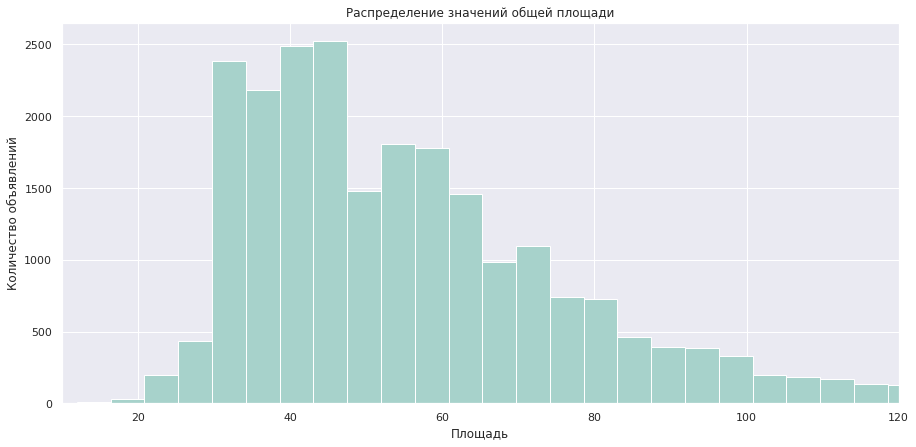

In [15]:
data['total_area'].hist(bins = 200, figsize = (15, 7), color='#A7D2CB')
plt.xlim(10, 120)

plt.title('Распределение значений общей площади')
plt.xlabel('Площадь') 
plt.ylabel('Количество объявлений')
plt.show()

**Вывод:** Основная масса объявлений, судя по гистограмме, приходится на квартиры площадью примерно от 40 до 70 кв м. Пик приходится на 50. На графике видны аномально маленькие (до 20 кв м) и аномально большие квартиры (400 кв м и выше). Удалим выбивающиеся значения.

**Жилая площадь**

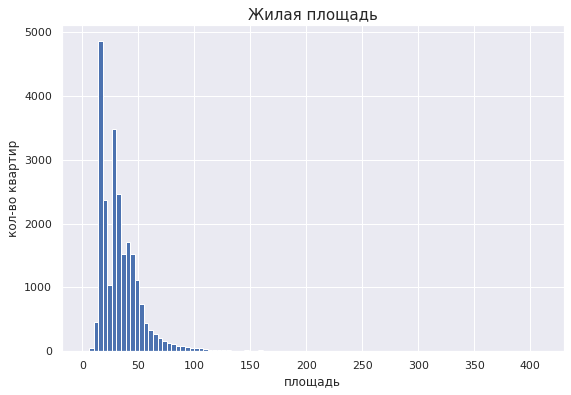

In [16]:
data['living_area'].hist(bins=100, figsize=(9,6));
plt.title('Жилая площадь', size=15);
plt.xlabel('площадь');
plt.ylabel('кол-во квартир');

**Вывод:** Стандартное отклонение составляет 22. Площадь варьируется от 2 до 409 кв м. Примем за выброс значения<10 и >300.

**Площадь кухни**

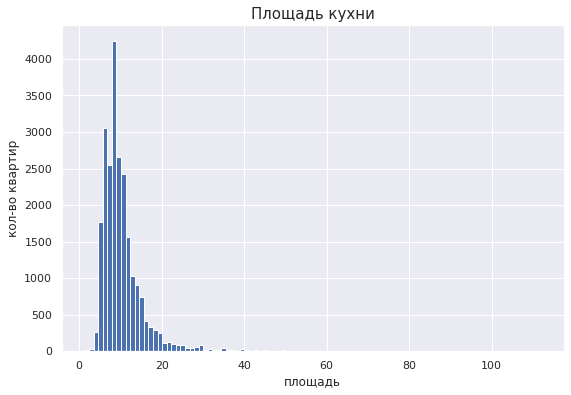

In [17]:
data['kitchen_area'].hist(bins=100, figsize=(9,6));
plt.title('Площадь кухни', size=15);
plt.xlabel('площадь');
plt.ylabel('кол-во квартир');

**Вывод:** Стандартное отклонение равно 5.9. Не такое высокое, как в пердыдуших столбцах, но и не близко к 1. Значит выбросы присутствуют. Основная доля квартир имеет площадь кухни от 5 до 15 кв м. Медианное и среднее значения практически совпадают. Значит выбросов не так много. Удалим только самые критичные значения <3 и >100.

**Цена объекта**

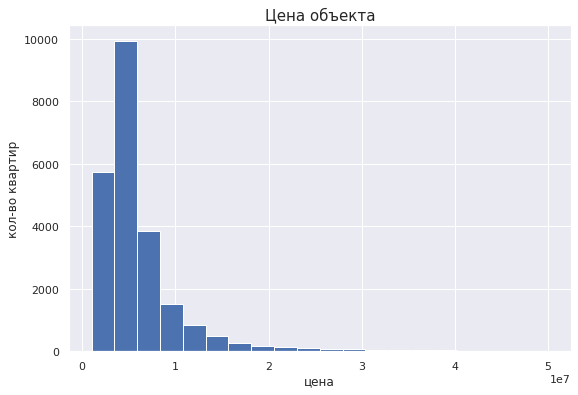

In [18]:
data['last_price'].hist(bins=20, figsize=(9,6), range=(1000000,50000000));
plt.title('Цена объекта', size=15);
plt.xlabel('цена');
plt.ylabel('кол-во квартир');

Цена квартир начинается от 12000. Таких маленьких цен не бывает на квартиры. Это явно ошибка.
Построим новую гистограмму, задав диапозон range, для более наглядного представления. А также построим ящик с усами.

Основная доля квартир продавалась в дипазоне цен от 3400000 до 6800000.

Попробуем рассчитать выбросы на основании 'ящика с усами'.

(0.0, 50000000.0)

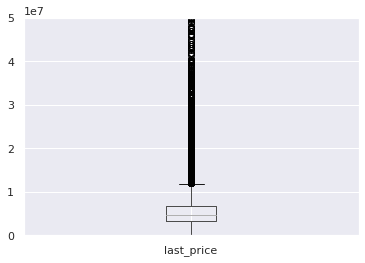

In [19]:
data.boxplot(column=['last_price']);
plt.ylim(0, 50000000)

In [20]:
data['last_price'].describe()

count       23699.00000
mean      6541548.77155
std      10887013.26754
min         12190.00000
25%       3400000.00000
50%       4650000.00000
75%       6800000.00000
max     763000000.00000
Name: last_price, dtype: float64

In [21]:
q = st.quantiles(data['last_price'])
lower_bound = q[0]-1.5*(q[2]-q[0])
upper_bound = q[2]+1.5*(q[2]-q[0])
print(lower_bound, upper_bound)

-1700000.0 11900000.0


**Вывод:** Возьмем верхнюю границу выброса из расчета (11900000). Нижнюю границу примем за 1 млн.

**Количество комнат**

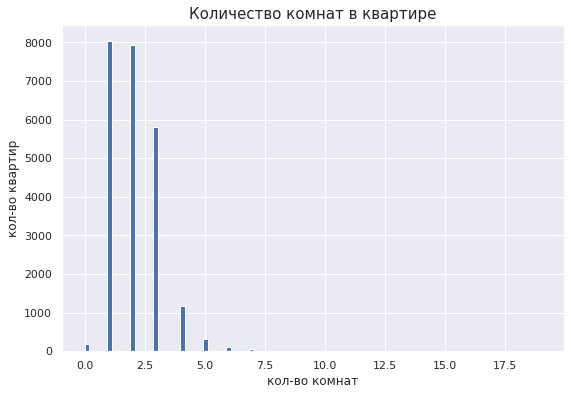

In [22]:
data['rooms'].hist(bins=100, figsize=(9,6));
plt.title('Количество комнат в квартире', size=15);
plt.xlabel('кол-во комнат');
plt.ylabel('кол-во квартир');

**Вывод:** В соотвествии с гистограммой основная часть квартир имеет одну, две или три комнаты.
Все, что <0 и >7 можно считать аномалиями.

**Высота потолков**

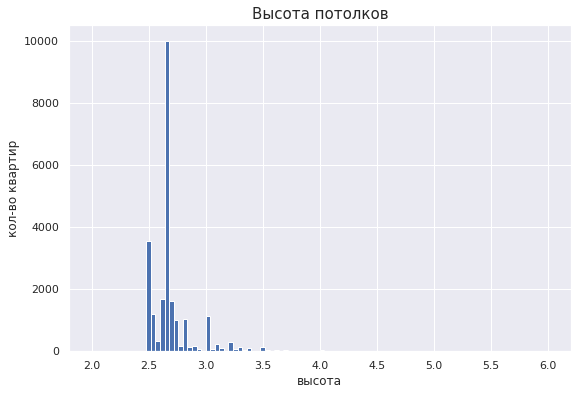

In [23]:
data['ceiling_height'].hist(bins=100, figsize=(9,6), range=(2,6));
plt.title('Высота потолков', size=15);
plt.xlabel('высота');
plt.ylabel('кол-во квартир');

Минимальная высота потолко 1м (слишком низко), максимальная - 100м. Попробуем обработать аномалии, чтобы минимизировать выбросы.
В столбце есть значения 20. , 22.6, 24. , 25. , 26. , 27. , 27.5. Эти значения похожи на ошибку формата ввода данных. Заменим эти значния на нормальные, разделив на 10. И построим гистограмму еще раз.

In [24]:
#Проверим какие двухзначные значения есть в столбце.
data.query('ceiling_height>10')['ceiling_height'].sort_values().unique()

array([ 10.3,  14. ,  20. ,  22.6,  24. ,  25. ,  26. ,  27. ,  27.5,
        32. , 100. ])

In [25]:
#Заменим занчения, чтобы сократить аномалии
data['ceiling_height'] = [x/10 if x>=20 and x<60 else x for x in data['ceiling_height']]

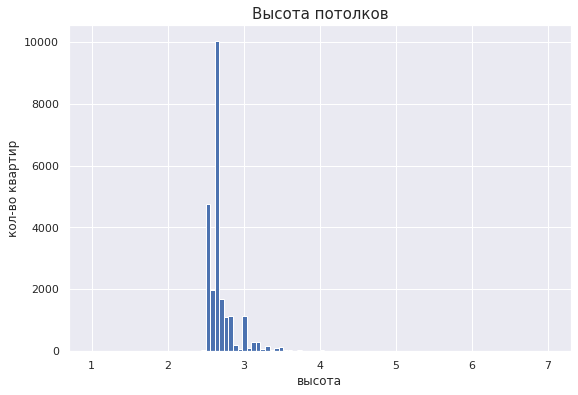

In [26]:
data['ceiling_height'].hist(bins=100, range=(1,7), figsize=(9,6));
plt.title('Высота потолков', size=15);
plt.xlabel('высота');
plt.ylabel('кол-во квартир');

**Вывод:** Большинство квартир имеют высоту потолков от 2.5 до 3 метров. Исключим высоту потолков до 2 и выше 6 метров.

**Общее количество этажей в доме**

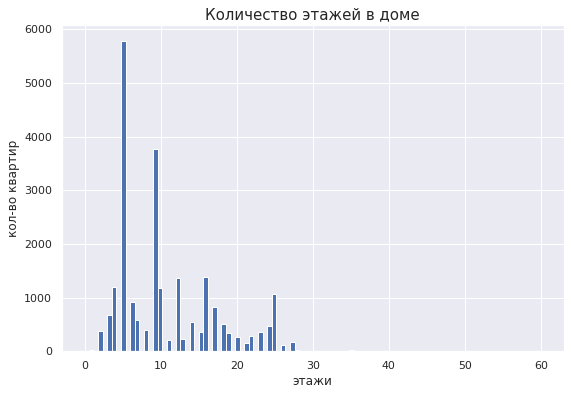

In [27]:
data['floors_total'].hist(bins=100, range=(0,60),figsize=(9,6));
plt.title('Количество этажей в доме', size=15);
plt.xlabel('этажи');
plt.ylabel('кол-во квартир');

**Вывод:** Избавимся от нулевых значений (их всего 87) и исключим кол-во этажей>36

**Расстояние до центра города** и **Расстояние до ближайшего парка**

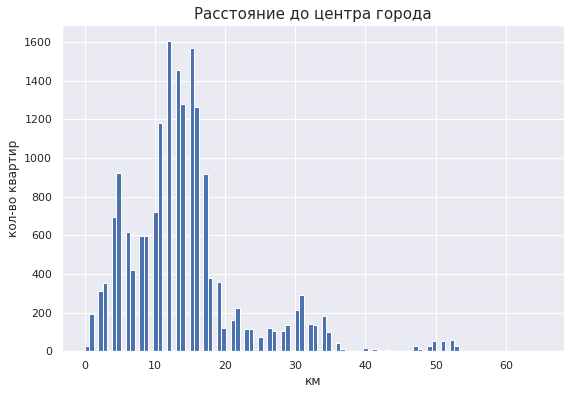

In [28]:
data['cityCenters_nearest'].hist(bins=100, range=(0,65),figsize=(9,6));
plt.title('Расстояние до центра города', size=15);
plt.xlabel('км');
plt.ylabel('кол-во квартир');

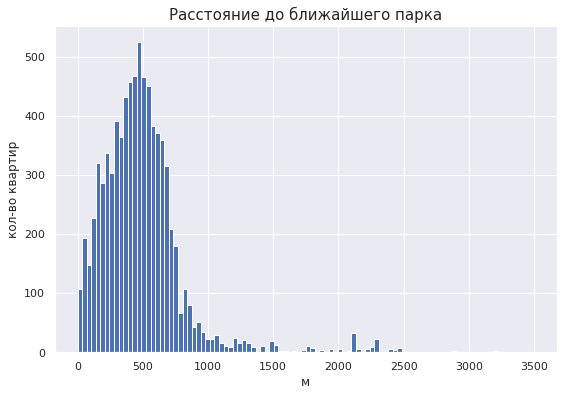

In [29]:
data['parks_nearest'].hist(bins=100, range=(0,3500),figsize=(9,6));
plt.title('Расстояние до ближайшего парка', size=15);
plt.xlabel('м');
plt.ylabel('кол-во квартир');

**Вывод:**

Некорректным будет приянть высокую удаленность от центра за выброс, т.к. мы анализируем данные не только в рамках Санкт-Петербурга, но и соседних населенных пунктов.

Нулевые значения параметра с ближайшими парками также нельзя принять за аномалии (отсутсвие парка поблизости является важной характеристикой объекта недвижимости).

Оставим два параметра без изменений.

In [30]:
#Делаем срез и сохраняем в data_cleared, чтобы можно было сравнить с исходным датафреймом data в случае необходимости
data_cleared = data.query('\
((total_area >=20) & (total_area<=400))\
&((living_area >=10) & (total_area<=300))\
&((kitchen_area >=3) & (kitchen_area<=100))\
&((last_price >=1000000) & (last_price<=11900000))\
&((rooms >=1) & (rooms<=7))\
&((ceiling_height >=2) & (ceiling_height<=6))\
&((floors_total >=1) & (floors_total<=36))')
data_cleared[list].describe()

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floors_total,cityCenters_nearest,parks_nearest
count,21116.00000,21116.00000,21116.00000,21116.00000,21116.00000,21116.00000,21116.00000,15942.00000,6661.00000
mean,53.72893,30.78610,9.57912,4911717.93872,1.95397,2.67331,10.76795,14.97535,488.02732
std,19.01428,13.35202,3.79239,2201741.12958,0.89969,0.18293,6.59072,8.58831,327.84413
min,20.00000,10.00000,3.00000,1000000.00000,1.00000,2.00000,1.00000,0.00000,1.00000
25%,39.44250,18.60000,7.00000,3398750.00000,1.00000,2.60000,5.00000,11.00000,289.00000
50%,50.00000,29.40000,9.00000,4490000.00000,2.00000,2.65000,9.00000,14.00000,456.00000
75%,64.00000,39.30000,11.00000,6000000.00000,3.00000,2.70000,16.00000,17.00000,613.00000
max,230.00000,131.32532,64.00000,11900000.00000,7.00000,5.30000,36.00000,66.00000,3190.00000


**Вывод**

Таким образом, в результате устранения аномалий, было удалено 2583 строки. Для дальнейшего анализа сохранено 89 % данных.

### Исследование количества дней для продажи квартиры

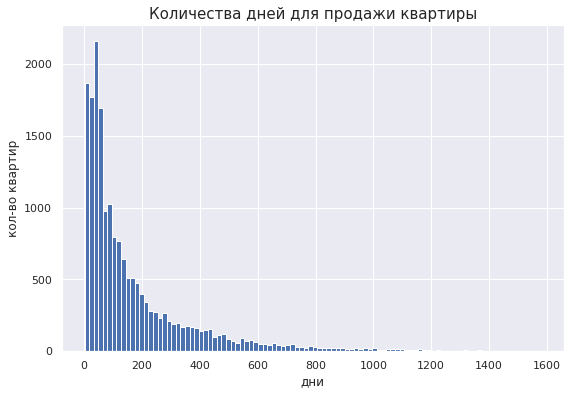

In [31]:
data_cleared['days_exposition'].hist(bins=100, figsize=(9,6));
plt.title('Количества дней для продажи квартиры',size=15);
plt.xlabel('дни');
plt.ylabel('кол-во квартир');

In [32]:
data_cleared['days_exposition'].describe()

count   18545.00000
mean      174.09992
std       212.35372
min         1.00000
25%        44.00000
50%        92.00000
75%       221.00000
max      1580.00000
Name: days_exposition, dtype: float64

**Вывод**

Обычно уходит примерно 92 дня на продажу квартиры.
Быстрыми продажами можно считать продажи, на которые потребовалаось меньше 44 дней (< 0,25 квантиль). Долгими продажами - дольше 221 дня (все, что лежит за передлами 0,75 квантиль).

### Исследование факторов, влияющих на полную стоимость квартиры

In [33]:
data_cleared[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type',\
              'week_day','month', 'year']].corr()['last_price']#Выведем коэффициент кореляции

last_price      1.00000
total_area      0.69915
living_area     0.58705
kitchen_area    0.50155
rooms           0.45078
week_day       -0.01387
month           0.00577
year            0.00173
Name: last_price, dtype: float64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


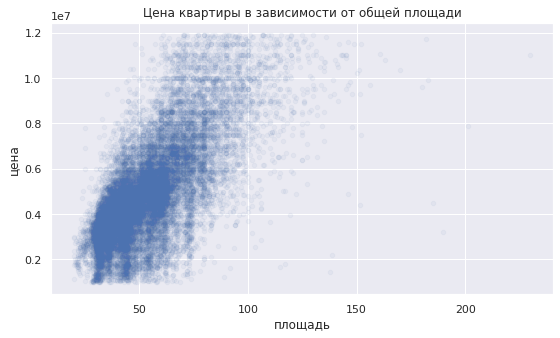

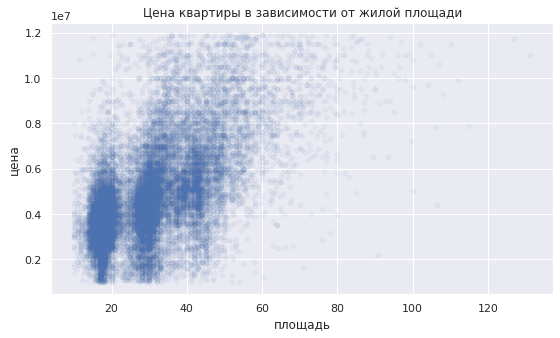

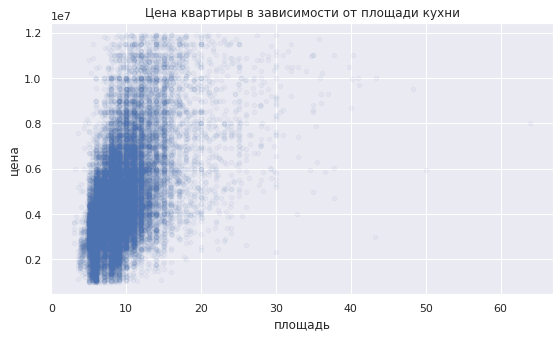

In [34]:
#factors=['total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type','week_day','month', 'year']
data_cleared.plot(x='total_area', y='last_price', kind='scatter', grid=True, alpha=0.05,\
                  title='Цена квартиры в зависимости от общей площади', xlabel='площадь', ylabel='цена', figsize=(9, 5));
data_cleared.plot(x='living_area', y='last_price', kind='scatter', grid=True, alpha=0.05,\
                  title='Цена квартиры в зависимости от жилой площади', xlabel='площадь', ylabel='цена', figsize=(9, 5));
data_cleared.plot(x='kitchen_area', y='last_price', kind='scatter', grid=True, alpha=0.05,\
                  title='Цена квартиры в зависимости от площади кухни', xlabel='площадь', ylabel='цена', figsize=(9, 5));

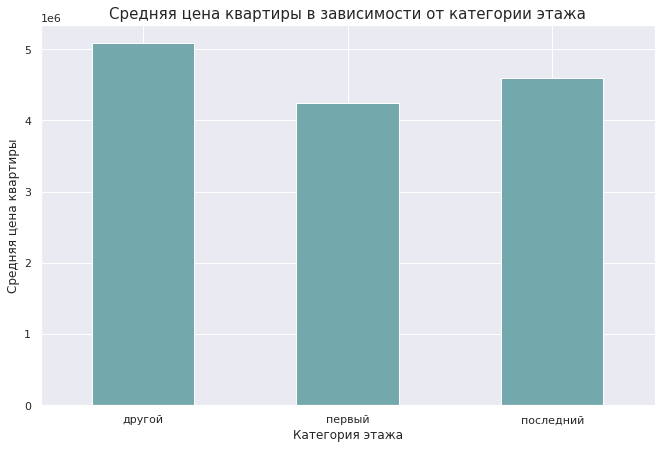

In [35]:
data_cleared.groupby('floor_type')['last_price'].mean().plot(kind='bar', figsize=(11, 7), color='#73A9AD')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от категории этажа', size=15)
plt.xlabel('Категория этажа', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

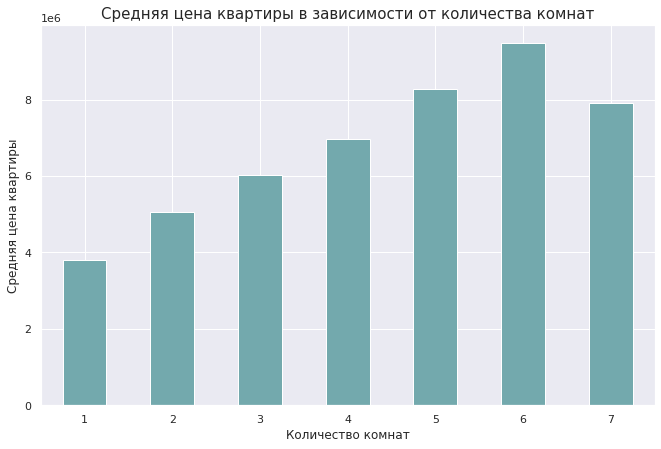

In [36]:
data_cleared.groupby('rooms')['last_price'].mean().plot(kind='bar', figsize=(11, 7), color='#73A9AD')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от количества комнат', size=15)
plt.xlabel('Количество комнат', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

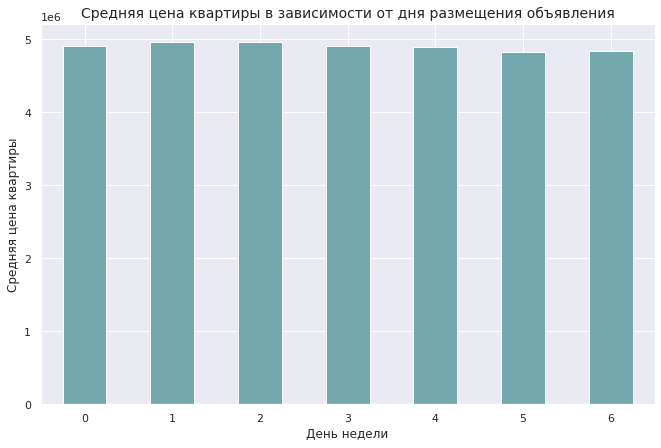

In [37]:
data_cleared.groupby('week_day')['last_price'].mean().plot(kind='bar', figsize=(11, 7), color='#73A9AD')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от дня размещения объявления', size=14)
plt.xlabel('День недели', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

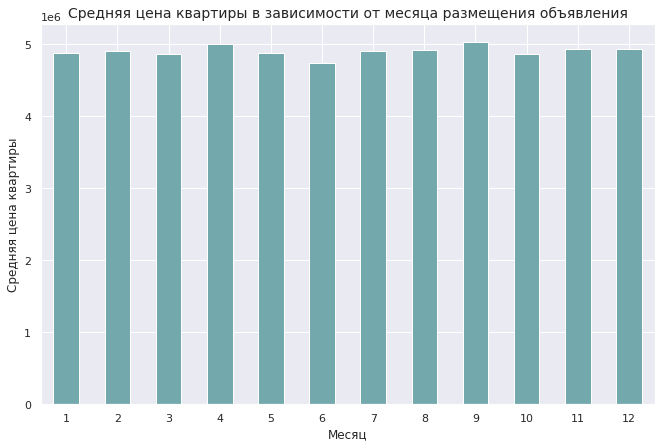

In [38]:
data_cleared.groupby('month')['last_price'].mean().plot(kind='bar', figsize=(11, 7), color='#73A9AD')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от месяца размещения объявления', size=14)
plt.xlabel('Месяц', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

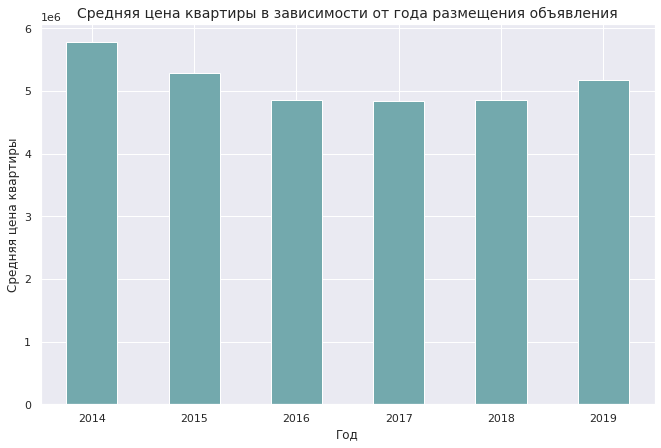

In [39]:
data_cleared.groupby('year')['last_price'].mean().plot(kind='bar', figsize=(11, 7), color='#73A9AD')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от года размещения объявления', size=14)
plt.xlabel('Год', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

Проверим сколько всего было размещено объявлений по дням,месяцам и годам.

In [40]:
timing = ['week_day', 'month', 'year']
for t in timing:
    timing_pivoted = data_cleared.pivot_table(index=t, values='first_day_exposition', aggfunc='count').sort_values(by='first_day_exposition')
    timing_pivoted.columns=(['количество_объявлений'])
    display(timing_pivoted)

,количество_объявлений
week_day,
6,1527
5,1727
0,3229
2,3519
4,3584
1,3746
3,3784


,количество_объявлений
month,
5,1129
1,1320
12,1463
7,1504
8,1560
6,1580
9,1753
10,1907
11,2097


,количество_объявлений
year,
2014,89
2015,998
2016,2470
2019,2557
2017,7313
2018,7689


**Вывод**

- Самый большой коэффициент корреляции 0,7 между ценой и общей площадью квартиры. Площадь квартиры имеет самое большое влияние на цену. Чем больше площадь, тем выше цена. При этом интересно, что для большей площади квартир характерна более выраженная зависиомсть от цены. На графике это видно, начиная с 75 кв м. Квартиры с меньшей площадью имеют больший разброс по цене (на них, видимо, оказывают большое влияние и другие факторы, например, район квратиры).
- Жилая площадь, площадь кухни и количество комнат так же, как и общая площадь, занчительно влияют на цену и имеют на нее прямое влияние. При этом эти факторы зависят от общей площади квартиры, поэтому повторяют вышеуказанные паттерны.
- Квартирам на первом и последнем этижах характерна более низка цена.

Прямой зависимости цены от даты размещения объявления нет. Но можно отметить следующие особенности, если еще взять во внимание общее количество размещенных объявлений:

- Меньше всего объявлений размещают в выходные дни, особенно на дорогие квартиры. Квартиры по средней цене размещают практичсеки стабильно во все дни недели.
- Меньше всего объявлений размещают в январе и в мае. Возможно это связано с большим количеством праздничных дней.
- Наибольшее число объявлений было размещено в 2017 и 2018 гг. В 2019 г., в основном, размещали объявления по средней цене. Мало объявлений с дешевыми и дорогими квартирами.

### Анализ десяти населённых пунктов с наибольшим числом объявлений, анализ стоимости квадратного метра

In [41]:
data_cleared_piv=data_cleared.pivot_table(index='locality_name', values='square_meter_price',\
                         aggfunc=('count', 'mean')).sort_values(by='count', ascending=False).head(10)
data_cleared_piv = data_cleared_piv.reset_index()
data_cleared_piv.columns=['населенный_пункт','количество_объявлений','средн_цена_за_метр']
data_cleared_piv

,населенный_пункт,количество_объявлений,средн_цена_за_метр
0,Санкт-Петербург,13550,105278.80902
1,Мурино,558,85470.68642
2,Кудрово,447,94900.26917
3,Шушары,434,78303.21270
4,Всеволожск,390,67217.73197
5,Пушкин,338,100265.89376
6,Колпино,336,75185.47824
7,Парголово,323,90289.77802
8,Гатчина,304,68611.12773
9,Выборг,232,58475.37845


Населённый пункт с самой высокой стоимостью квадратного метра:

In [42]:
data_cleared_piv.loc[data_cleared_piv['средн_цена_за_метр']==max(data_cleared_piv['средн_цена_за_метр'])]

,населенный_пункт,количество_объявлений,средн_цена_за_метр
0,Санкт-Петербург,13550,105278.80902


Населённый пункт с самой низкой стоимостью квадратного метра:

In [43]:
data_cleared_piv.loc[data_cleared_piv['средн_цена_за_метр']==min(data_cleared_piv['средн_цена_за_метр'])]

,населенный_пункт,количество_объявлений,средн_цена_за_метр
9,Выборг,232,58475.37845


### Анализ изменения цены квадратного метра в Санкт-Петербурге для каждого километра по степени удалённости от центра

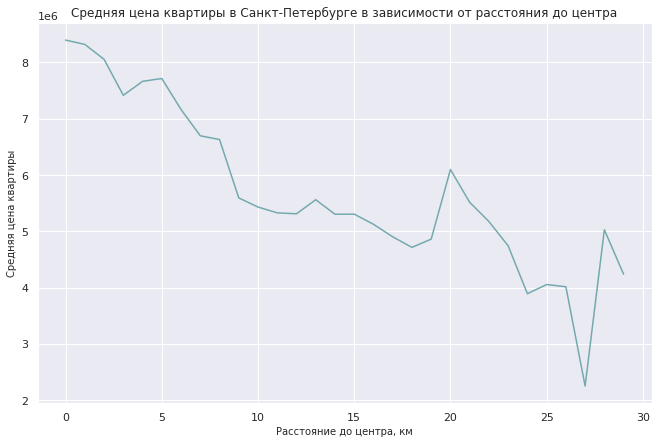

In [44]:
data_cleared_spb = data_cleared.query('locality_name == "Санкт-Петербург"')
data_cleared_spb.groupby('cityCenters_nearest')['last_price'].mean().plot(figsize=(11, 7), color='#73A9AD')

plt.title('Средняя цена квартиры в Санкт-Петербурге в зависимости от расстояния до центра', size=12)
plt.xlabel('Расстояние до центра, км', size=10)
plt.ylabel('Средняя цена квартиры', size=10)

plt.show()


**Вывод**

На графике видна отрицательная корреляция. Чем дальше от центра, тем ниже цена. Основная часть дорогих квартир находится в переделах 1-16 км от центра города.

## Общий вывод

Были получены данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.
Задача — провести исследовательский анализ данных, который поможет установить параметры, влияющие на цену объектов.

**На этапе предобработки были внесены следующие изменения в данные:**
- Обработаны пропуски данных: 
  - Замены на 0 пропуски в столбцах `balcony`, `parks_around3000`, `ponds_around3000`. Заменены пропуски в столбце `is_apartment` на False. Заполнены пропуски в столбце `living_area`, `kitchen_area` (с помощью коэффициента соотношения к срдн общей площади). Заполнены пропуcки в столбце `ceiling_height` медианным занчением.
- Заменены типы данных:
  - Тип данных `object` в столбце `first_day_exposition` заменен на `daytime`.
  - Вещественный тип данных `float` был заменен на `int` в столбцах `balcony`, `parks_around3000`, `ponds_around3000`. 
- Устранены неявные дубликаты в названиях населённых пунктов.
- Устранены выбивающиеся значения (аномалии) в 7 столбцах:
  - общая площадь; жилая площадь; площадь кухни; цена объекта; количество комнат; высота потолков; общее количество этажей в доме.
- Добавлены новые столбцы:
  - цена одного квадратного метра; день, месяц и год публикации объявления; тип этажа квартиры; расстояние до центра города в километрах.

**Выводы**

- Наибольшее влияние на цену объекта недвижимости имеет общая плошадь квартиры. Для нее характерен самый большой коэффициент корреляции 0,7. Чем больше площадь, тем выше цена. При этом интересно, что для большей площади квартир характерна более выраженная зависиомсть от цены. Квартиры с меньшей площадью имеют больший разброс по цене (на них, видимо, оказывают сильное влияние и другие факторы, например, район квратиры).
- Жилая площадь, площадь кухни и количество комнат так же, как и общая площадь, занчительно влияют на цену и имеют на нее прямое влияние. При этом эти факторы зависят от общей площади квартиры, поэтому повторяют вышеуказанные паттерны.
- Квартирам на первом и последнем этижах характерна более низкая цена. Другие этажи не оказывают заметного влияния на цену.
- Населенный пункт также оказывает существенное влияние на цену квартиры. Средняя стоимость квадратного метра в Санкт-Петербурге практически в 2 раза превышает этот показатель в Выборге.
- Степень удаленности от центра города также имеет большое влиянние на цену. Между этим показателем и ценой наблюдается отрицательная корреляция. Чем дальше от центра, тем ниже цена.

В результате анализа были также выявлены следующие закономерности:
- Меньше всего объявлений размещают в выходные дни, особенно на дорогие квартиры. Квартиры по средней цене размещают практичсеки стабильно во все дни недели.
- Меньше всего объявлений размещают в январе и в мае. Возможно это связано с большим количеством праздничных дней.

**Рекомендации**

На основании проведенного анализа данных рекомендуем включить в автоматизированную систему проверки объектов недвижимости следующие парметры, оказывающие существенное влияние на цену объекта:

- общая плошадь
- жилая площадь (опционно, повторяет паттерн с общей площадью)
- площадь кухни (опционно, повторяет паттерн с общей площадью)
- этаж (на цену вляет только первый/последний этаж)
- населенный пункт (необходимо отталкиваться от средней цены квадратного метра в каждом населенном пункте)
- степень удаленности от центра города
